In [1]:
import os
from random import shuffle
import json
from itertools import product, combinations
from time import perf_counter

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
import seaborn as sns

from src.models.monuseg.models import get_model
from src.data.monuseg.tf_data import get_dataset, tf_random_crop
from src.models.loss import dice_coe_loss, dice_coe_metric
from src.models.monuseg.evaluation import post_processing
from src.models.monuseg.metrics import confusion_indices

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

path_indices = "/home/valentin/python_wkspce/2d_bispectrum_cnn/data/indices/monuseg.json"
split = 0

In [2]:
w_fg = 1.9
w_border = 5.0
w_bg = 0.44


def loss(y_true, y_pred):
    l = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    w = (y_true[..., 0] * w_fg + y_true[..., 1] * w_border +
         y_true[..., 2] * w_bg)
    return tf.reduce_mean(w * l, axis=(1, 2))

In [3]:
with open(path_indices, "r") as f:
    indices_list = json.load(f)

ds_train = get_dataset(id_list=indices_list[split]["train"]).take(1)
ds_train = ds_train.cache().repeat(15)
f1 = lambda image, seg: tf_random_crop(
    image, seg, rotation_angle="right-angle")
f2 = lambda image, seg: (
    tf.image.random_brightness(image, max_delta=0.2),
    seg,
)
ds_train = ds_train.map(f1).map(f2).batch(4)

ds_val = get_dataset(id_list=indices_list[split]["val"])
ds_val = ds_val.cache().batch(1)

ds_val_instance = get_dataset(id_list=indices_list[split]["val"],
                              instance=True)
ds_val_instance = ds_val_instance.cache().batch(1)

ds_test = get_dataset(id_list=indices_list[split]["test"], instance=True)
ds_test = ds_test.cache().batch(1)


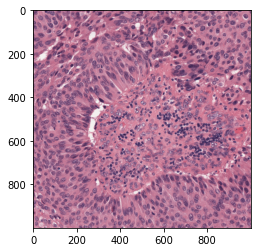

In [4]:
images, segs = next(ds_test.as_numpy_iterator())
plt.imshow(images[0,...])

In [5]:
def rotate_batch(images, angle=90):
    output = np.zeros_like(images)
    for n in range(images.shape[0]):
        output[n, ...] = rotate(images[n, ...], angle=angle, reshape=False)
    return output


In [6]:
model = get_model(
    model_name="BispectUnet",
    output_channels=3,
    n_harmonics=8,
    n_feature_maps=[8, 16, 32],
    radial_profile_type="disks",
)


In [7]:
ds_sample = ds_test.as_numpy_iterator()

In [8]:
x, y = next(ds_sample)

In [9]:
x.shape

(1, 1000, 1000, 3)

In [10]:
x = x[:, :256, :256, :]
y = y[:, :256, :256, :]
x.shape

(1, 256, 256, 3)

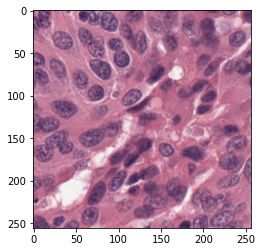

In [11]:
plt.imshow(x[0,...])

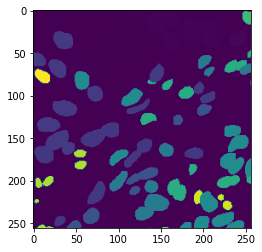

In [12]:
plt.imshow(y[0,...])

In [13]:
y_pred = model(x)

In [14]:
model.load_weights(
    "/home/valentin/python_wkspce/2d_bispectrum_cnn/models/MoNuSeg/BispectUnet__rotation_True__nh_8__n_train_-1__psize_60x60__20211202-173734/weights/split_0/final"
)


In [15]:
angle = 90
x_rotated = rotate_batch(x, angle=angle)

In [16]:
y_pred = model(x)
y_pred_2 = rotate_batch(model(x_rotated), -angle)

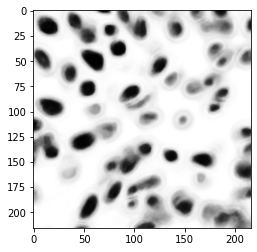

In [17]:
plt.imshow(y_pred[0,:,:,0], cmap="binary")

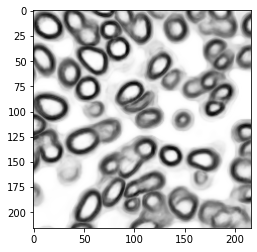

In [18]:
plt.imshow(y_pred[0,:,:,1], cmap="binary")

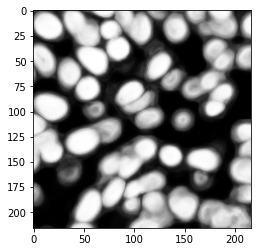

In [19]:
plt.imshow(y_pred[0,:,:,2], cmap="binary")

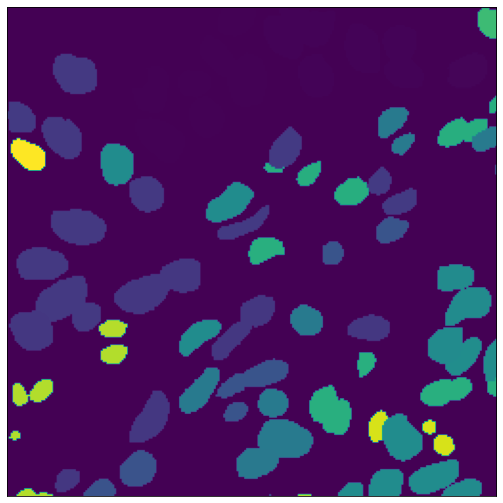

In [20]:
plt.figure(figsize=(9, 9))
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.imshow(y[0, ...])

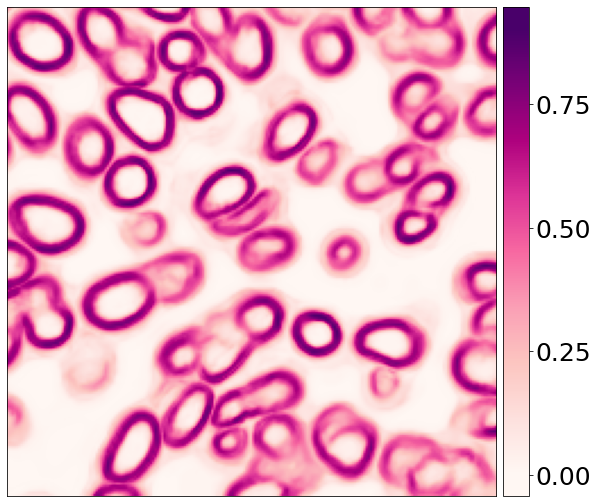

In [21]:
fig = plt.figure(figsize=(9, 9))
ax = plt.axes()
im = ax.imshow(y_pred[0, :, :, 1], cmap="RdPu")
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
cax = fig.add_axes([
    ax.get_position().x1 + 0.01,
    ax.get_position().y0, 0.04,
    ax.get_position().height
])
cbar = plt.colorbar(im,
                  cax=cax,
                  extend="both",
                  extendrect=True,
                  ticks=np.linspace(0, 1, 5))
cbar.ax.tick_params(labelsize=25)


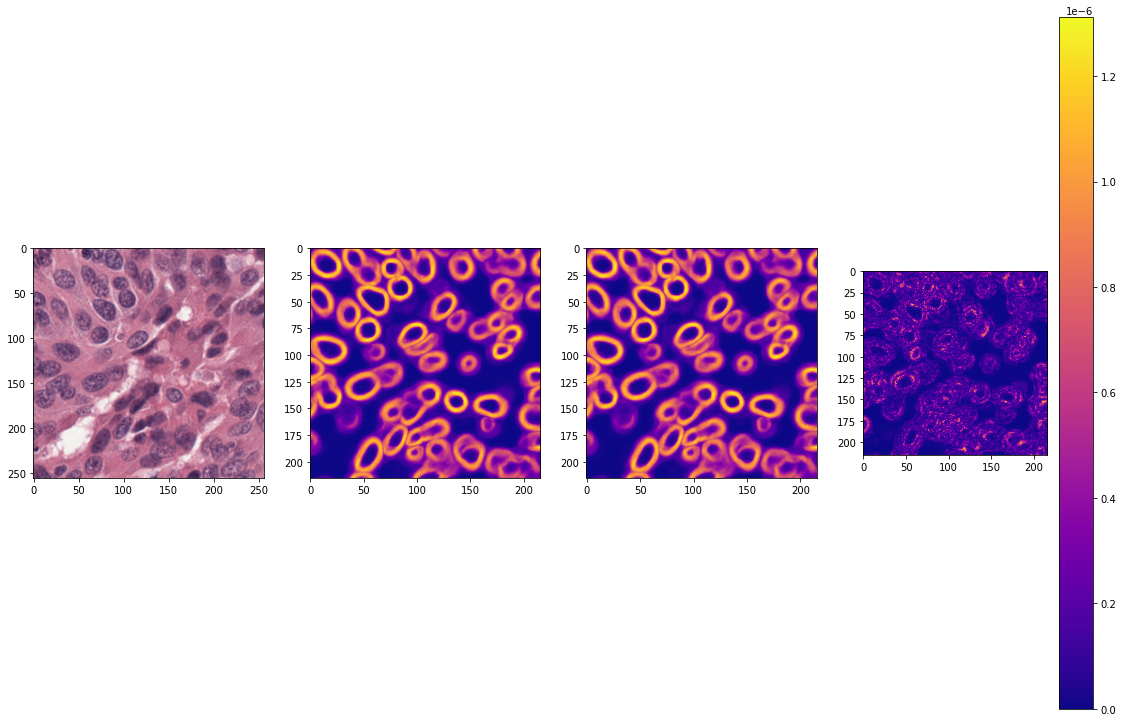

In [22]:
fig = plt.figure(figsize=(19, 19))
plt.subplot(141)
plt.imshow(x[0, ...])
plt.subplot(142)
plt.imshow(y_pred[0, :, :, 1], cmap="plasma")
plt.subplot(143)
plt.imshow(y_pred_2[0, :, :, 1], cmap="plasma")
ax = plt.subplot(144)
im = ax.imshow(np.abs(y_pred - y_pred_2)[0, :, :, 1], cmap="plasma")
fig.colorbar(im, ax=ax)


In [23]:
unet = get_model(
    model_name="MaskedUnet",
    output_channels=3,
    n_feature_maps=[8, 16, 32],
)


In [24]:
unet.load_weights(
    "/home/valentin/python_wkspce/2d_bispectrum_cnn/models/MoNuSeg/MaskedUnet__rotation_True__nh_0__n_train_-1__psize_60x60__20211212-222429/weights/split_0/final"
)


In [25]:
y_pred_2 = unet(x)
y_pred_2 = rotate_batch(unet(x_rotated), -angle)

In [26]:
def compute_image_error(
    model,
    x,
    ouput_shape=(1, 216, 216, 3),
    rotations=[0, 45, 90, 135, 180, 225, 270, 315],
):
    errors = np.zeros(ouput_shape)
    n = 0
    for r1, r2 in combinations(rotations, 2):
        pred_1 = rotate_batch(model(rotate_batch(x, r1)), -r1)
        pred_2 = rotate_batch(model(rotate_batch(x, r2)), -r2)
        errors += np.sqrt((pred_1 - pred_2)**2)
        n += 1
    return errors / n


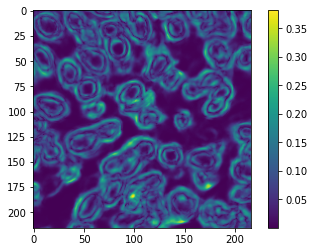

In [27]:
errors = compute_image_error(unet, x,rotations=[0,90,180,270])
plt.imshow(errors[0,:,:,1])
plt.colorbar()

In [28]:
np.max(errors[0,:,:,1])

0.3815537989139557

In [29]:
def disk(size):
    output = np.zeros((size, size))
    x = np.linspace(-size // 2, size // 2, num=size)
    x, y = np.meshgrid(x, x, indexing="xy")
    radius = np.sqrt(x**2 + y**2)
    output[radius <= size // 2 + 1] = 1
    return output


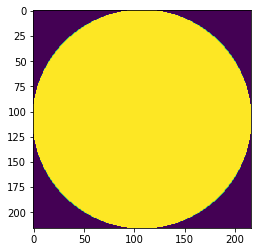

In [30]:
plt.imshow(disk(216))

In [31]:
x[0, ...].shape


(256, 256, 3)

In [32]:
delta_deg = 45
rotations = [k * delta_deg for k in range(int(360 / delta_deg))]

<Figure size 648x648 with 0 Axes>

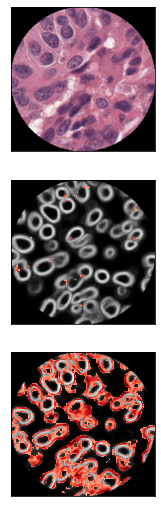

In [33]:
plt.figure(figsize=(9, 9))
fig, axs = plt.subplots(3, 1, figsize=(9, 9))
# cmaps = [None, 'binary', 'binary']
cmaps = [None, 'gray', 'gray']
mask_disk = disk(216)
images = [x[0, ...], model(x)[0, :, :, 1], unet(x)[0, :, :, 1]]
images_error = [
    np.zeros((216, 216)),
    compute_image_error(model, x, rotations=rotations)[0, :, :, 1] * disk(216),
    compute_image_error(unet, x, rotations=rotations)[0, :, :, 1] * disk(216),
]
for row in range(3):
    ax = axs[row]
    if row > 0:
        pcm = ax.imshow(images[row] * mask_disk,
                        cmap=cmaps[row],
                        vmin=0.0,
                        vmax=1.0)
        # plt.colorbar(pcm)
    else:
        im = tf.keras.layers.Cropping2D((20, 20))(images[row][np.newaxis, ...])
        pcm = ax.imshow(im[0, ...] * mask_disk[..., np.newaxis],
                        cmap=cmaps[row])
    masked = np.ma.masked_where(images_error[row] < 0.05, images_error[row])
    err = ax.imshow(masked, cmap="Reds", alpha=0.99, vmin=0.0, vmax=0.2)
    # plt.colorbar(err)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
plt.savefig("sample_2.png", bbox_inches='tight')

In [34]:
np.min(images_error[1][disk(216)!=0])

8.830933698586056e-09

In [74]:
def evaluate_forward_time(model, images, n_rep=10):
    t1 = perf_counter()
    n_images = 0
    for _ in range(n_rep):
        for x in images:
            y_pred = model(x)
            n_images += 1
    t2 = perf_counter()
    return {
        "elapsed_time": t2 - t1,
        "n_images": n_images,
        "average_elapsed_time": (t2 - t1) / n_images,
    }


In [36]:
images = list()
for x, _ in ds_test:
    images.append(x)

In [37]:
len(images)

8

In [91]:
unet_nhx = get_model(
    model_name="BispectUnet",
    output_channels=3,
    n_harmonics=3,
    n_feature_maps=[8, 16, 32],
    radial_profile_type="disks",
)

In [92]:

unet_nhx.load_weights(
    "/home/valentin/python_wkspce/2d_bispectrum_cnn/models/MoNuSeg/BispectUnet__rotation_True__nh_3__n_train_-1__psize_60x60__20211212-222438/weights/split_0/final"
)

In [93]:
evaluate_forward_time(unet_nhx, images)

{'elapsed_time': 34.25971255451441,
 'n_images': 80,
 'average_elapsed_time': 0.4282464069314301}

In [80]:
evaluate_forward_time(model, images)

{'elapsed_time': 173.78862664476037,
 'n_images': 80,
 'average_elapsed_time': 2.172357833059505}

In [81]:
evaluate_forward_time(unet, images)

{'elapsed_time': 5.923616636544466,
 'n_images': 80,
 'average_elapsed_time': 0.07404520795680583}

In [ ]:
n, bins, patches = plt.hist(x=images_error[1][disk(216)!=0].flatten(), bins='auto', 
                            alpha=0.7, rwidth=0.85)

In [ ]:
n, bins, patches = plt.hist(x=images_error[2][disk(216)!=0].flatten(), bins='auto', 
                            alpha=0.7, rwidth=0.85)

In [ ]:
plt.figure(figsize=(9, 9))
fig, axs = plt.subplots(1, 4, figsize=(9, 9))
cropper = tf.keras.layers.Cropping2D((20,20))
images = [
    cropper(x)[0, ...],
    post_processing(model(x))[0, ...],
    post_processing(unet(x))[0, ...],
    cropper(y)[0, ...],
]
cmaps = [None, 'gray', 'gray', 'gray']
for row, ax in enumerate(axs):
    pcm = ax.imshow(images[row], cmap=cmaps[row])


In [ ]:
y_pred = post_processing(model(x))

In [ ]:
cropper(y).shape

In [ ]:
# find missing predictions in bisp not in standard
# opposite
# same for FP
(matched_pred_indices, unmatched_pred_indices,
 unmatched_true_indices) = confusion_indices(
     cropper(y).numpy()[0, :, :, 0],
     y_pred,
 )


In [ ]:
np.unique(y_pred).shape

In [ ]:
len(matched_pred_indices)

In [ ]:
np.unique(matched_pred_indices).shape

In [ ]:
len(unmatched_pred_indices)

In [ ]:
len(unmatched_true_indices)

In [ ]:
np.unique(unmatched_true_indices).shape

In [ ]:
np.unique(cropper(y).numpy()[0, ..., 0]).astype(int).shape


In [ ]:
50/71